In [1]:
## Imports
import os
import sys
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as k

In [2]:
from google.colab.patches import cv2_imshow

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [50]:
# Fetching Data from drive
img_xtrain_path = '/content/drive/MyDrive/MoNuSeg-Training-Data/Tissue-Images'

img_list = next(os.walk(img_xtrain_path))[2][:30]

In [51]:
# Fetching Data from drive
img_xtest_path = '/content/drive/MyDrive/MoNuSeg-Test-Data/Tissue-Images'

img_x_test_list = next(os.walk(img_xtest_path))[2][:30]

In [52]:
# Fetching Data from drive
img_ytrain_path = '/content/drive/MyDrive/MoNuSeg-Training-Data/Binary-Mask'

img_y_list = next(os.walk(img_xtrain_path))[2][:30]

In [53]:
# Fetching Data from drive
img_ytest_path = '/content/drive/MyDrive/MoNuSeg-Test-Data/Binary-Mask'

img_y_test_list = next(os.walk(img_ytest_path))[2][:30]

In [113]:
# Loading images in an array and resizing it
img_xtrain_df = []
for i in range(30):
  img_xtrain_df.append(cv2.resize(cv2.imread(img_xtrain_path + "/" + img_list[i]), (256,256)))

In [13]:
img_xtrain_df.shape

TensorShape([30, 256, 256, 3])

In [114]:
# Loading images in an array and resizing it
img_ytrain_df = []
for i in range(30):
  img_ytrain_df.append(cv2.resize(cv2.imread(img_ytrain_path + "/" + img_y_list[i], 0), (256,256)))

In [115]:
# Loading images in an array and resizing it
img_xtest_df = []
for i in range(14):
  img_xtest_df.append(cv2.resize(cv2.imread(img_xtest_path + "/" + img_x_test_list[i]), (256,256)))

In [116]:
# Loading images in an array and resizing it
img_ytest_df = []
for i in range(14):
  img_ytest_df.append(cv2.resize(cv2.imread(img_ytest_path + "/" + img_y_test_list[i], 0), (256,256)))

**SHOWING TRAINING AND TESTING IMAGES**

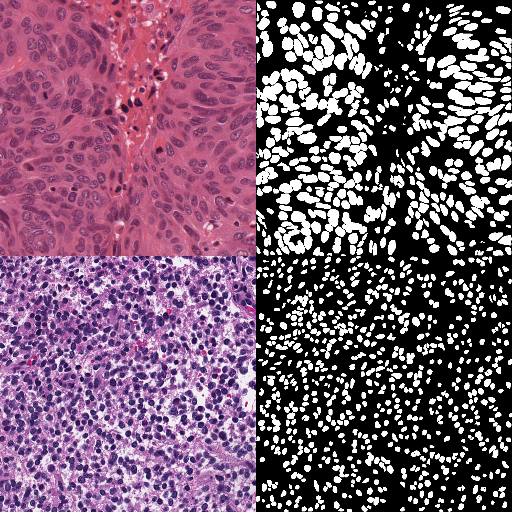

In [16]:
# Displaying Training and Data with Output
cv2_imshow(np.vstack((np.hstack((img_xtrain_df[0], img_ytrain_df[0])), np.hstack((img_xtrain_df[1], img_ytrain_df[1])))))

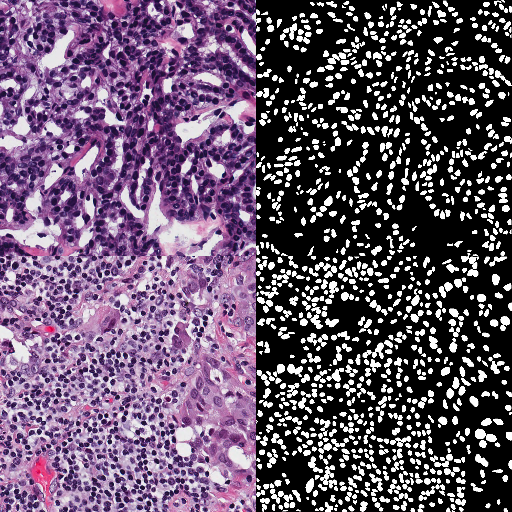

In [17]:
# Displaying Testing Data with Outputs
cv2_imshow(np.vstack((np.hstack((img_xtest_df[0], img_ytest_df[0])), np.hstack((img_xtest_df[1], img_ytest_df[1])))))

In [18]:
# For these Functions I took help from youtube video provided by professor as didnt knew syntax for keras 
def DownSampling(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)    # Convolving with filter of size (3,3) and activation relu to bring non linearity
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)    # Convolving the outputn of above filter of size (3,3) and activation relu to bring non linearity
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)                                                            # DownSampling
    return c, p

def UpSampling(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)                                                                # UpSampling the input
    concat = keras.layers.Concatenate()([us, skip])                                                          # Concatinating the layers
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)    # Now convolving with avtivation relu
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)    # Regular Convolving
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

In [136]:
# Defining UNET Model as per youtube video provided by professor
# Tried differet number of down blocks and up blocks three down and three up seems to give decent outcome (not the best)
def UNet():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((256,256, 3))                                   # Input Layer
    
    p0 = inputs
    c1, p1 = DownSampling(p0, f[0]) #128 -> 64                                    # Convolving and down Sampling as described in above functions
    c2, p2 = DownSampling(p1, f[1]) #64 -> 32
    c3, p3 = DownSampling(p2, f[2]) #32 -> 16
    #c4, p4 = down_block(p3, f[3]) #16->8
    
    #bn = bottleneck(p4, f[4])
    bn = bottleneck(p3, f[3])
    
    u1 = UpSampling(bn, c3, f[2]) #16 -> 32                                       # Convolving and up sampling as described in above functions
    u2 = UpSampling(u1, c2, f[1]) #32 -> 64
    u3 = UpSampling(u2, c1, f[0]) #64 -> 128
    #u4 = up_block(u3, c1, f[0]) #64 -> 128
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u3)        # Using activation sigmoid for last layer to get PDF per pixel
    model = keras.models.Model(inputs, outputs)
    return model

In [87]:
# Creating Dice loss function
# Formula for Dice loss was reffered from google
def dice_Loss(y_true, y_pred):
    numerator = 1 + 2 * tf.reduce_sum(y_true * y_pred)               
    denominator = tf.reduce_sum(y_true + y_pred) + 1

    return 1 - (numerator / denominator)

In [ ]:
# Complining UNET Model with loss as dice_Loss
model = UNet()
model.compile(optimizer="SGD", loss = dice_Loss, metrics = ["acc"])
model.summary()

In [ ]:
# Normalizing input image function
def normalize(input_image):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  return input_image

In [117]:
# Normalizing the inputs and outputs
img_xtrain_df = normalize(img_xtrain_df)
img_ytrain_df = normalize(img_ytrain_df)

In [118]:
# Converting the inputs to tensor as required for model
img_xtrain_df = tf.convert_to_tensor(img_xtrain_df)
img_ytrain_df = tf.convert_to_tensor(img_ytrain_df)
img_xtest_df =  tf.convert_to_tensor(img_xtest_df)

In [138]:
# fitting the model to our data 
tf.config.run_functions_eagerly(True)
model.fit(img_xtrain_df,img_ytrain_df , validation_split = 0.1, batch_size = 3, epochs = 4)

Epoch 1/4


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


9/9 [==============================] - 23s 2s/step - loss: 0.6686 - acc: 0.7117 - val_loss: 0.6084 - val_acc: 0.6293
Epoch 2/4
9/9 [==============================] - 27s 3s/step - loss: 0.6652 - acc: 0.7025 - val_loss: 0.6060 - val_acc: 0.5928
Epoch 3/4
9/9 [==============================] - 22s 2s/step - loss: 0.6625 - acc: 0.5895 - val_loss: 0.6038 - val_acc: 0.3852
Epoch 4/4
9/9 [==============================] - 26s 3s/step - loss: 0.6605 - acc: 0.2959 - val_loss: 0.6018 - val_acc: 0.2917


In [174]:
pred = model.predict(img_xtest_df)   # Predicting the model

1/1 [==============================] - 3s 3s/step


**3. Train the UNet using Dice loss, and show Dice score on validation and test data.**

In [176]:
# Calculating mean Dice Loss for predicted images
sum = 0
for i in range(14):
  sum += dice_Loss(img_ytest_df[i].reshape(256,256,1), pred[i])

print("Mean Dice Loss over all images:", sum/14)

Mean Dice Loss over all images: tf.Tensor(0.76497823, shape=(), dtype=float32)


In [171]:
for i in range(len(pred)):
  pred[i] = (pred[i] > 0.3)*255    # Denormalizing the output with threshold for PDF Function as 0.3

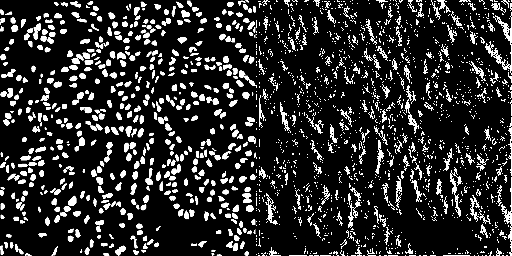

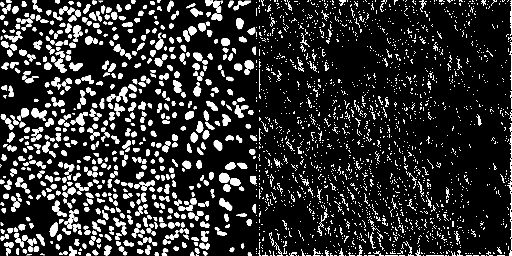

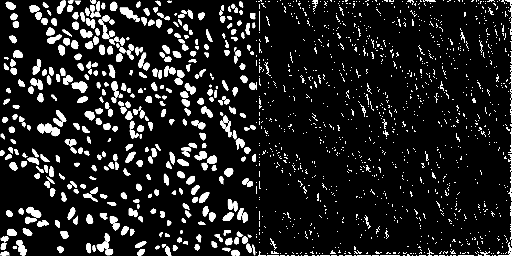

In [172]:
for i in range(3):
  cv2_imshow(np.hstack((img_ytest_df[i].reshape((256,256,1)), pred[i])))  # Output of predict and expected output

**5c. Loss function as a combination of Dice and MS-SSIM with a trade-off parameter**

In [177]:
def SSIM(img1, img2, var = 1):
  gaussian_weights = np.random.normal(0.5 ,var , size = (256, 256))             # Creating a gaussian white noise
  ssim = 0 

  ux1 = np.mean(img1)                                                           # Mean of img1
  ux2 = np.mean(img2)                                                           # mean of img2

  var1 = np.sum((img1 - ux1)**2)/(256*256)                                      # variance of img1
  var2 = np.sum((img2 - ux2)**2)/(256*256)                                      # variance of img2

  covar12 = np.sum((img1 - ux1)*(img1 - ux2))/(256**2)                          # Covariance of img1 and img2
  c1 = 0.01*255                                                                 # by deafualt C1, C2
  c2 = 0.03*255

  ssim = ((2*ux1*ux2 + c1)*(2*covar12 + c2))/((ux1**2 + ux2**2 + c1)*(var1 + var2 + c2))   # SSIM Formula

  return ssim

In [188]:
# Combined loss Function as dice Loss and SSIM with alpha as trade off parameter
def LossFunction(y_True, y_Pred, alpha = 0.5):
  loss = dice_Loss(y_True, y_Pred) + alpha*(SSIM(y_True, y_Pred))
  return loss

In [181]:
# Complining UNET Model with loss as LossFunction as above
model1 = UNet()
model1.compile(optimizer="SGD", loss = LossFunction, metrics = ["acc"])
model1.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_201 (Conv2D)            (None, 256, 256, 16  448         ['input_12[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_202 (Conv2D)            (None, 256, 256, 16  2320        ['conv2d_201[0][0]']             
                                )                                                          

In [182]:
model1.fit(img_xtrain_df,img_ytrain_df , validation_split = 0.1, batch_size = 3, epochs = 4)   # Loss Function as linear combination of dice loss and SSIm

Epoch 1/4
9/9 [==============================] - 25s 3s/step - loss: 0.8744 - acc: 0.7171 - val_loss: 0.8192 - val_acc: 0.6575
Epoch 2/4
9/9 [==============================] - 22s 2s/step - loss: 0.8706 - acc: 0.7237 - val_loss: 0.8181 - val_acc: 0.6648
Epoch 3/4
9/9 [==============================] - 22s 2s/step - loss: 0.8708 - acc: 0.7087 - val_loss: 0.8171 - val_acc: 0.5892
Epoch 4/4
9/9 [==============================] - 24s 3s/step - loss: 0.8723 - acc: 0.5864 - val_loss: 0.8162 - val_acc: 0.4867


In [ ]:
cv2.watershed(pred[0]/255, markers = )